# Image Processing CookBook
## Chapter 05
### Author: Sandipan Dey

### Image Alignment with ECC algorithm

992 610


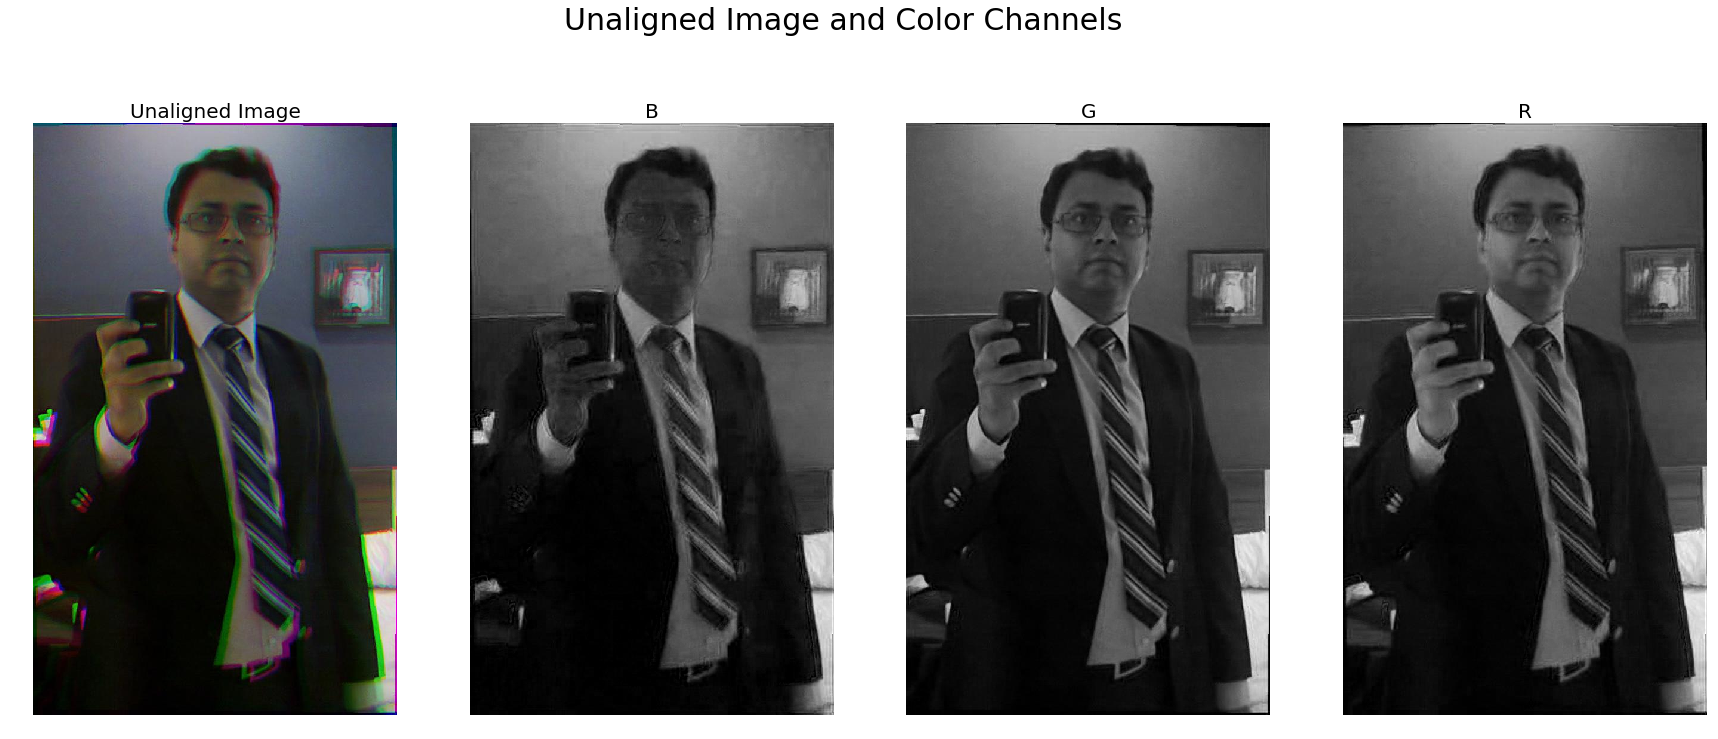

Processing Channel B...
[[ 9.9852240e-01 -7.3300595e-03  8.7293777e+00]
 [ 1.3443469e-02  9.9930155e-01 -3.7745864e+00]
 [-3.5765074e-06  2.5245824e-06  1.0000000e+00]]
Processing Channel G...
[[ 1.0092515e+00 -2.7040454e-02  8.6985931e+00]
 [ 2.6736395e-02  9.8989981e-01 -5.0035219e+00]
 [-6.7387623e-07  5.9878818e-07  1.0000000e+00]]


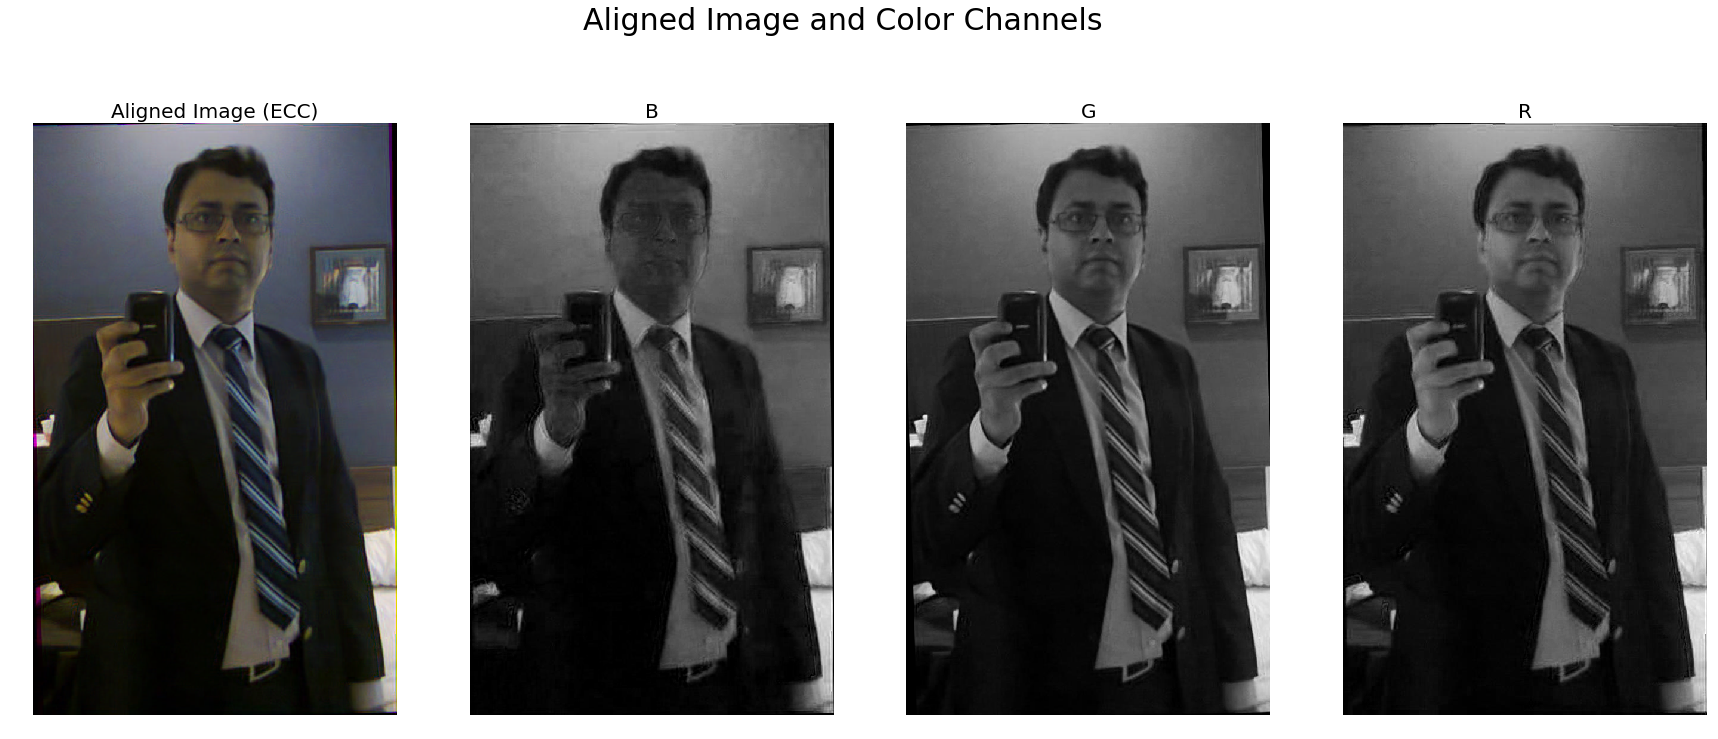

True

In [2]:
% matplotlib inline
import cv2
import numpy as np
import matplotlib.pylab as plt
 
def compute_gradient(im) :
    grad_x = cv2.Sobel(im,cv2.CV_32F,1,0,ksize=3)
    grad_y = cv2.Sobel(im,cv2.CV_32F,0,1,ksize=3)
    grad = cv2.addWeighted(np.absolute(grad_x), 0.5, np.absolute(grad_y), 0.5, 0)
    return grad

im_unaligned =  cv2.imread("images/me_unaligned.jpg")

height, width = im_unaligned.shape[:2]
print(height, width)

channels = ['B', 'G', 'R']

plt.figure(figsize=(30,12))
plt.gray()
plt.subplot(1,4,1), plt.imshow(cv2.cvtColor(im_unaligned, cv2.COLOR_BGR2RGB)), plt.axis('off'), plt.title('Unaligned Image', size=20)
for i in range(3):
    plt.subplot(1,4,i+2), plt.imshow(im_unaligned[...,i]), plt.axis('off'), plt.title(channels[i], size=20)
plt.suptitle('Unaligned Image and Color Channels', size=30)
plt.show()

im_aligned = np.zeros_like(im_unaligned)

# The blue and green channels will be aligned to the red channel.
# So copy the red channel
im_aligned[...,2] = im_unaligned[...,2]

# Define motion model
warp_mode = cv2.MOTION_HOMOGRAPHY

# Set the warp matrix to identity.
warp_matrix = np.eye(3, 3, dtype=np.float32) if warp_mode == cv2.MOTION_HOMOGRAPHY else np.eye(2, 3, dtype=np.float32)

# Set the stopping criteria for the algorithm.
criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 5000,  1e-10)

im_grad2 = compute_gradient(im_unaligned[...,2])

# Warp the blue and green channels to the red channel
for i in range(2) :
    print('Processing Channel {}...'.format(channels[i]))
    (cc, warp_matrix) = cv2.findTransformECC (im_grad2, compute_gradient(im_unaligned[...,i]),warp_matrix, warp_mode, criteria)

    if warp_mode == cv2.MOTION_HOMOGRAPHY :
        # Use Perspective warp when the transformation is a Homography
        im_aligned[...,i] = cv2.warpPerspective (im_unaligned[...,i], warp_matrix, (width,height), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
    else :
        # Use Affine warp when the transformation is not a Homography
        im_aligned[...,i] = cv2.warpAffine(im_unaligned[...,i], warp_matrix, (width, height), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP);
    print (warp_matrix)
    
channels = ['B', 'G', 'R']
plt.figure(figsize=(30,12))
plt.subplot(1,4,1), plt.imshow(cv2.cvtColor(im_aligned, cv2.COLOR_BGR2RGB)), plt.axis('off'), plt.title('Aligned Image (ECC)', size=20)
for i in range(3):
    plt.subplot(1,4,i+2), plt.imshow(im_aligned[...,i]), plt.axis('off'), plt.title(channels[i], size=20)
plt.suptitle('Aligned Image and Color Channels', size=30)
plt.show()

cv2.imwrite("images/me_aligned.jpg", im_aligned)

### Feature-based image alignment with ORB

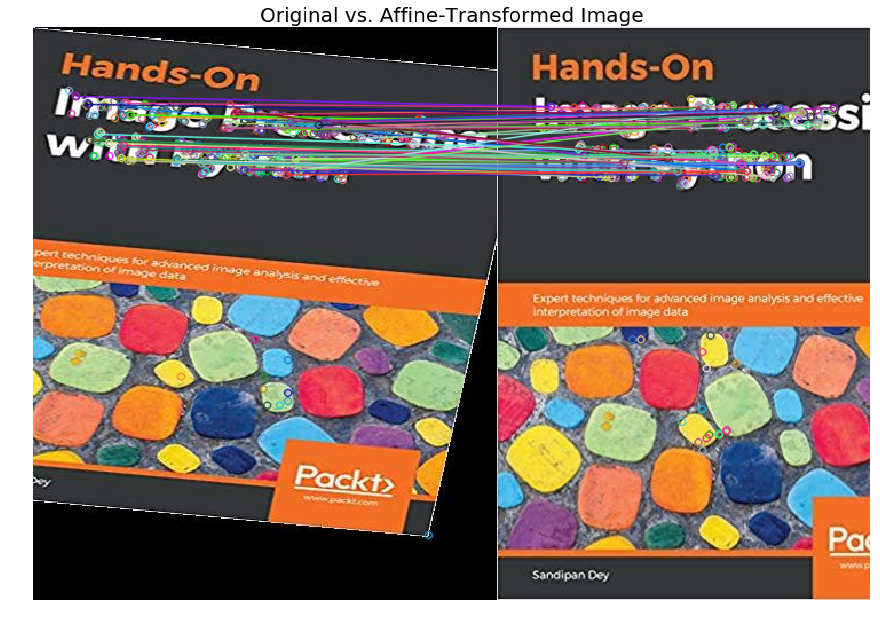


 Estimated homography : 
 [[ 8.90132747e-01  1.74068778e-01  4.52121708e+00]
 [-1.11327534e-01  1.17723294e+00  2.11909068e+00]
 [-1.18280055e-05 -6.27770905e-05  1.00000000e+00]]


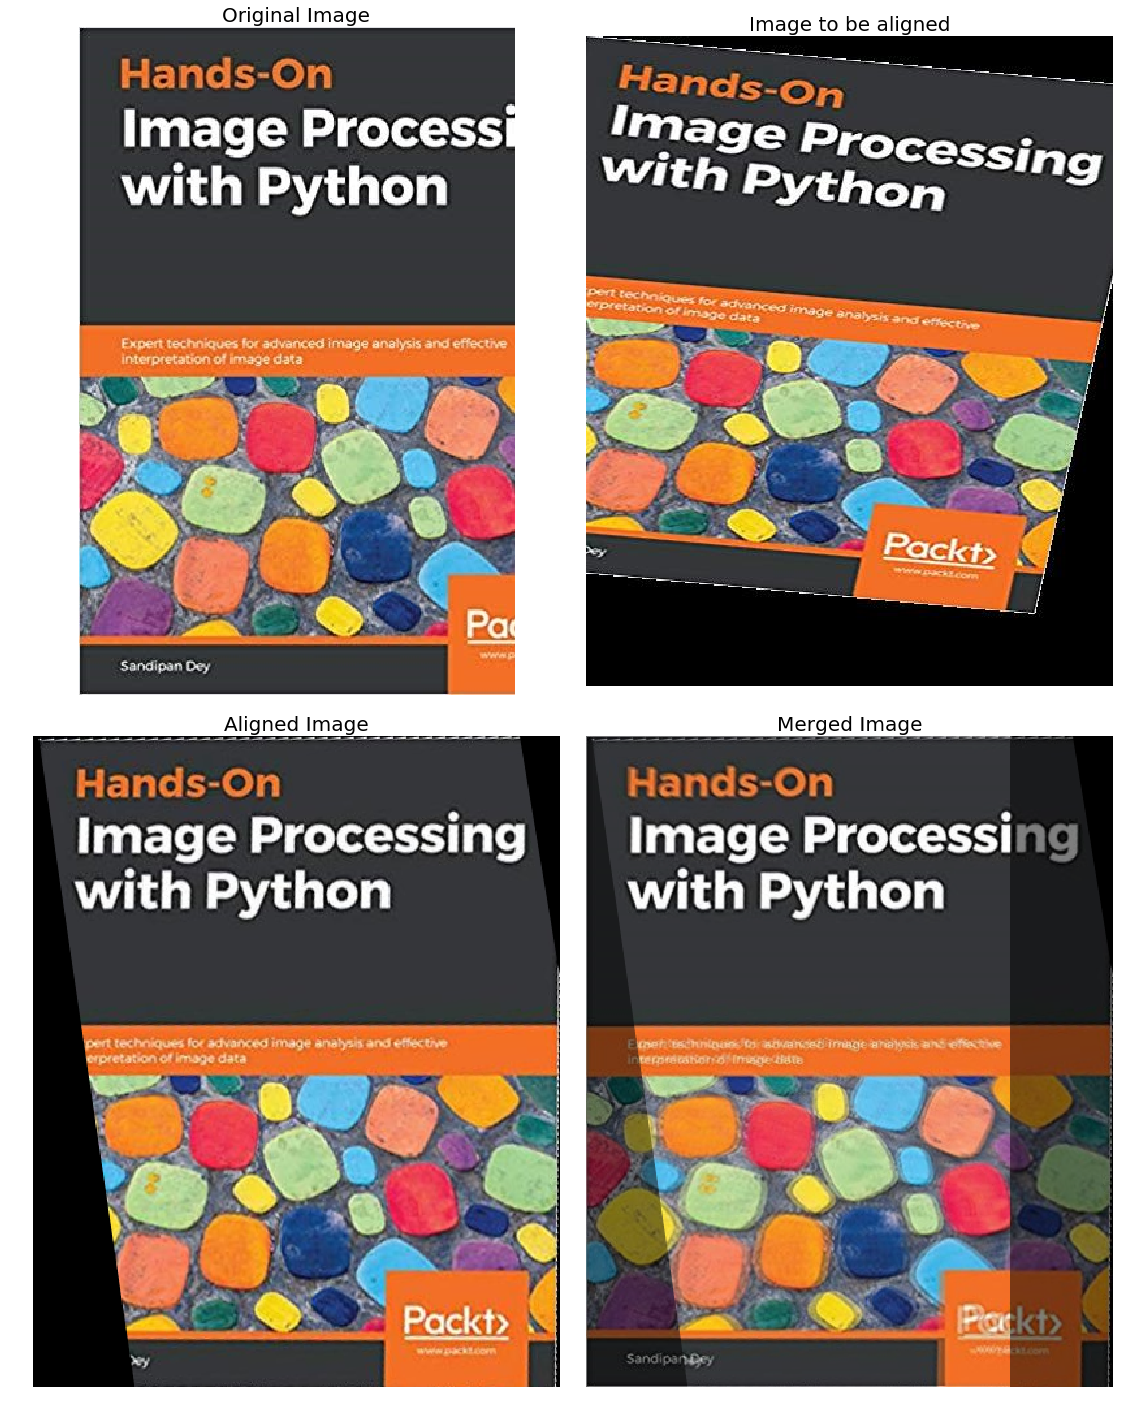

In [21]:
# https://stackoverflow.com/questions/41692063/what-is-the-difference-between-image-registration-and-image-alignment

import cv2
import numpy as np
import matplotlib.pylab as plt
 
 
MAX_FEATURES = 500
GOOD_MATCH_PERCENT = 0.15

# reference image
im_ref = cv2.imread('images/book_half.jpg') 
# images to be aligned
im1 = cv2.imread('images/book_affine.jpg') 

# Convert images to grayscale
im_ref_g = cv2.cvtColor(im_ref, cv2.COLOR_RGB2GRAY)
im1_g = cv2.cvtColor(im1, cv2.COLOR_RGB2GRAY)

# Detect ORB features and compute descriptors.
orb = cv2.ORB_create(MAX_FEATURES)
keypoints1, descriptors1 = orb.detectAndCompute(im1_g, None)
keypoints_ref, descriptors_ref = orb.detectAndCompute(im_ref_g, None)
   
# Match features.
matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
matches = matcher.match(descriptors1, descriptors_ref, None)
   
# Sort matches by score
matches.sort(key=lambda x: x.distance, reverse=False)
# Remove not so good matches
num_good_matches = int(len(matches) * GOOD_MATCH_PERCENT)
matches = matches[:num_good_matches]
 
# Draw top matches
im_matches = cv2.drawMatches(im1, keypoints1, im_ref, keypoints_ref, matches, None)
plt.figure(figsize=(15,12))
plt.imshow(cv2.cvtColor(im_matches, cv2.COLOR_BGR2RGB)), plt.axis('off'), plt.title('Original vs. Affine-Transformed Image', size=20)
plt.show()

def compute_alignment(matches, im, keypoints, keypoints_ref):
    # Extract location of good matches
    points = np.zeros((len(matches), 2), dtype=np.float32)
    points_ref = np.zeros((len(matches), 2), dtype=np.float32) 
    for i, match in enumerate(matches):
        points[i, :] = keypoints[match.queryIdx].pt
        points_ref[i, :] = keypoints_ref[match.trainIdx].pt   
    # Find homography
    h, mask = cv2.findHomography(points, points_ref, cv2.RANSAC)
    # Use homography
    height, width, channels = im.shape
    im_ref_reg = cv2.warpPerspective(im, h, (width, height))
    # Print estimated homography
    print("\n Estimated homography : \n",  h)
    return im_ref_reg

im_reg = compute_alignment(matches, im1, keypoints1, keypoints_ref)
#print(im_ref.shape, im_reg.shape)
im_ref1 = np.zeros_like(im_reg)
im_ref1[:im_ref.shape[0],:im_ref.shape[1],:] = im_ref
im_merged = cv2.addWeighted(im_ref1, 0.5, im_reg, 0.5, 0)

plt.figure(figsize=(15,20))
plt.subplots_adjust(left=0, right=1, bottom=0, top=0.95, wspace=0.05, hspace=0.05)
plt.subplot(221), plt.imshow(cv2.cvtColor(im_ref, cv2.COLOR_BGR2RGB)), plt.axis('off'), plt.title('Original Image', size=20)
plt.subplot(222), plt.imshow(cv2.cvtColor(im1, cv2.COLOR_BGR2RGB)), plt.axis('off'), plt.title('Image to be aligned', size=20)
plt.subplot(223), plt.imshow(cv2.cvtColor(im_reg, cv2.COLOR_BGR2RGB)), plt.axis('off'), plt.title('Aligned Image', size=20)
plt.subplot(224), plt.imshow(cv2.cvtColor(im_merged, cv2.COLOR_BGR2RGB)), plt.axis('off'), plt.title('Merged Image', size=20)
plt.show()

### Feature-based image alignment with SURF features

In [ ]:
# reference image
im_ref = cv2.imread('images/book_half.jpg') 
# images to be aligned
im1 = cv2.imread('images/book_affine.jpg') 

# Convert images to grayscale
im_ref_g = cv2.cvtColor(im_ref, cv2.COLOR_RGB2GRAY)
im1_g = cv2.cvtColor(im1, cv2.COLOR_RGB2GRAY)

# Detect ORB features and compute descriptors.
orb = cv2.ORB_create(MAX_FEATURES)
keypoints1, descriptors1 = orb.detectAndCompute(im1_g, None)
keypoints_ref, descriptors_ref = orb.detectAndCompute(im_ref_g, None)

# Create a SURF detector object
surf = cv2.xfeatures2d.SURF_create()
# find the keypoints and descriptors with SURF
keypoints1, descriptors1 = surf.detectAndCompute(im1_g, None)
keypoints_ref, descriptors_ref = surf.detectAndCompute(im_ref_g, None)

# Match features.
bf = cv2.BFMatcher()
matches = bf.knnMatch(descriptors1, descriptors_ref, k=2)
# Apply ratio test
good_matches = []
for m1, m2 in matches:
    if m1.distance < 0.75*m2.distance:
        good_matches.append([m1])
num_good_matches = len(good_matches)
    
# Draw good matches
im_matches = cv2.drawMatchesKnn(im1, keypoints1, im_ref, keypoints_ref, good_matches, None, flags=2)

plt.figure(figsize=(15,12))
plt.imshow(cv2.cvtColor(im_matches, cv2.COLOR_BGR2RGB)), plt.axis('off'), plt.title('Original vs. Affine-Transformed Image', size=20)
plt.show()

im_reg = compute_alignment([m[0] for m in good_matches], im1, keypoints1, keypoints_ref)
#print(im_ref.shape, im_reg.shape)
im_ref1 = np.zeros_like(im_reg)
im_ref1[:im_ref.shape[0],:im_ref.shape[1],:] = im_ref
im_merged = cv2.addWeighted(im_ref1, 0.5, im_reg, 0.5, 0)

plt.figure(figsize=(15,20))
plt.subplots_adjust(left=0, right=1, bottom=0, top=0.95, wspace=0.05, hspace=0.05)
plt.subplot(221), plt.imshow(cv2.cvtColor(im_ref, cv2.COLOR_BGR2RGB)), plt.axis('off'), plt.title('Original Image', size=20)
plt.subplot(222), plt.imshow(cv2.cvtColor(im1, cv2.COLOR_BGR2RGB)), plt.axis('off'), plt.title('Image to be aligned', size=20)
plt.subplot(223), plt.imshow(cv2.cvtColor(im_reg, cv2.COLOR_BGR2RGB)), plt.axis('off'), plt.title('Aligned Image', size=20)
plt.subplot(224), plt.imshow(cv2.cvtColor(im_merged, cv2.COLOR_BGR2RGB)), plt.axis('off'), plt.title('Merged Image', size=20)
plt.show()

### Face Morphing

[[91, 144], [88, 165], [87, 182], [90, 200], [97, 217], [110, 232], [122, 243], [141, 249], [167, 253], [190, 251], [205, 240], [218, 227], [231, 214], [242, 198], [248, 143], [251, 165], [249, 146], [118, 114], [128, 105], [139, 102], [150, 104], [156, 117], [185, 119], [190, 107], [200, 105], [211, 107], [222, 116], [170, 108], [170, 126], [169, 142], [169, 156], [150, 182], [160, 190], [171, 196], [181, 191], [192, 183], [128, 117], [136, 112], [143, 115], [147, 125], [139, 126], [131, 123], [194, 126], [198, 118], [206, 114], [213, 120], [207, 126], [199, 126], [138, 202], [148, 209], [158, 205], [171, 204], [183, 205], [193, 208], [205, 202], [204, 215], [192, 219], [179, 216], [164, 216], [152, 219], [140, 215], [155, 211], [173, 210], [185, 212], [205, 218], [184, 215], [171, 213], [157, 215], [123, 109], [224, 120]]


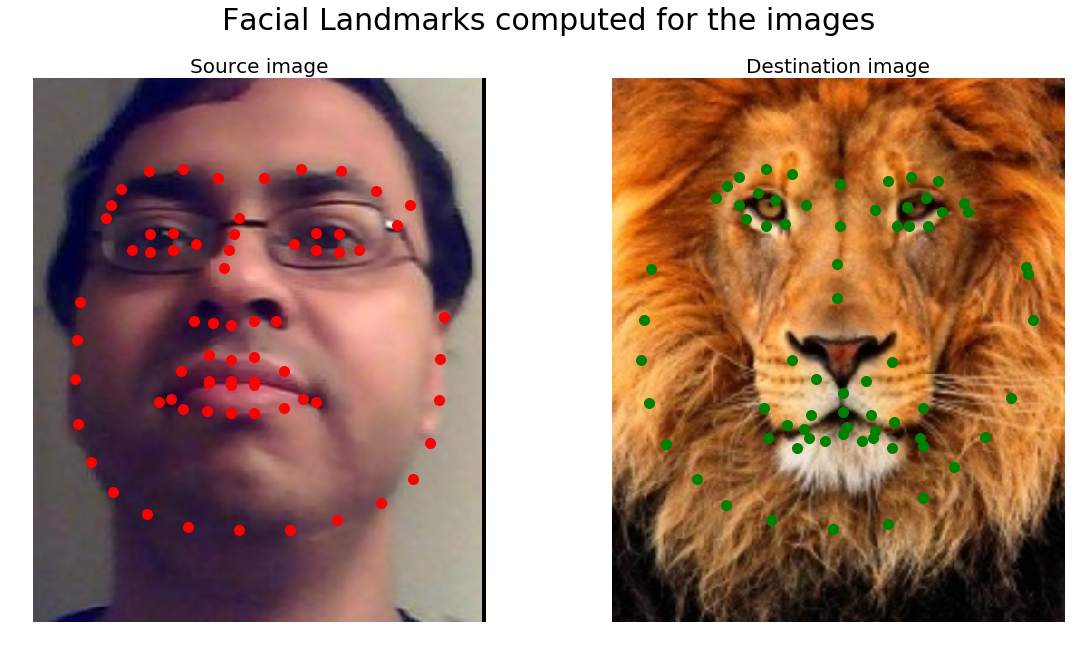

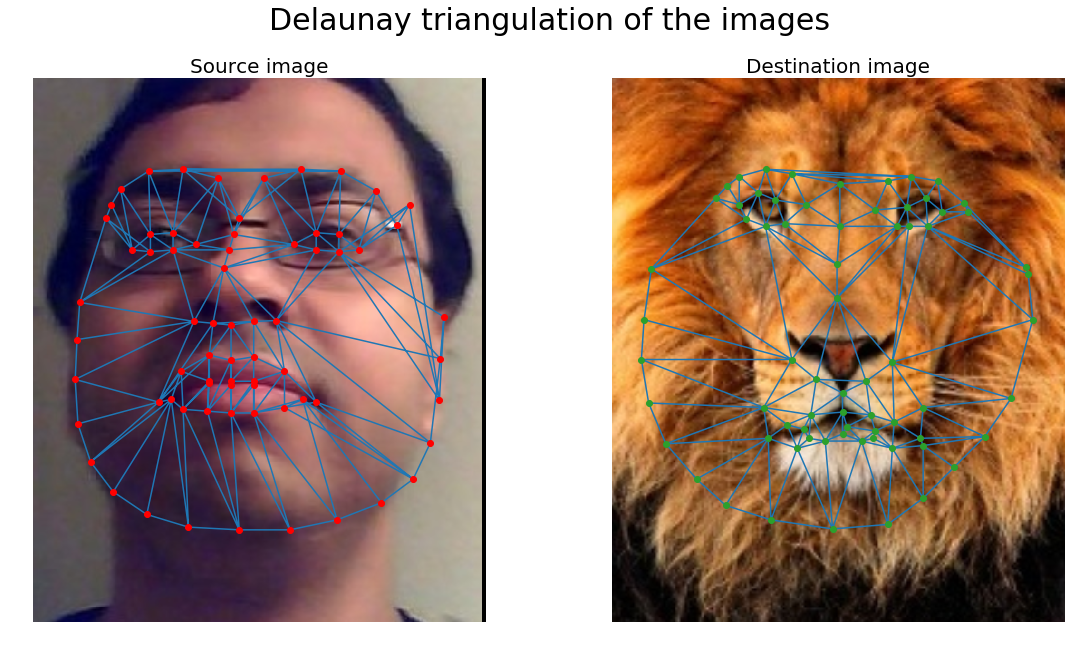

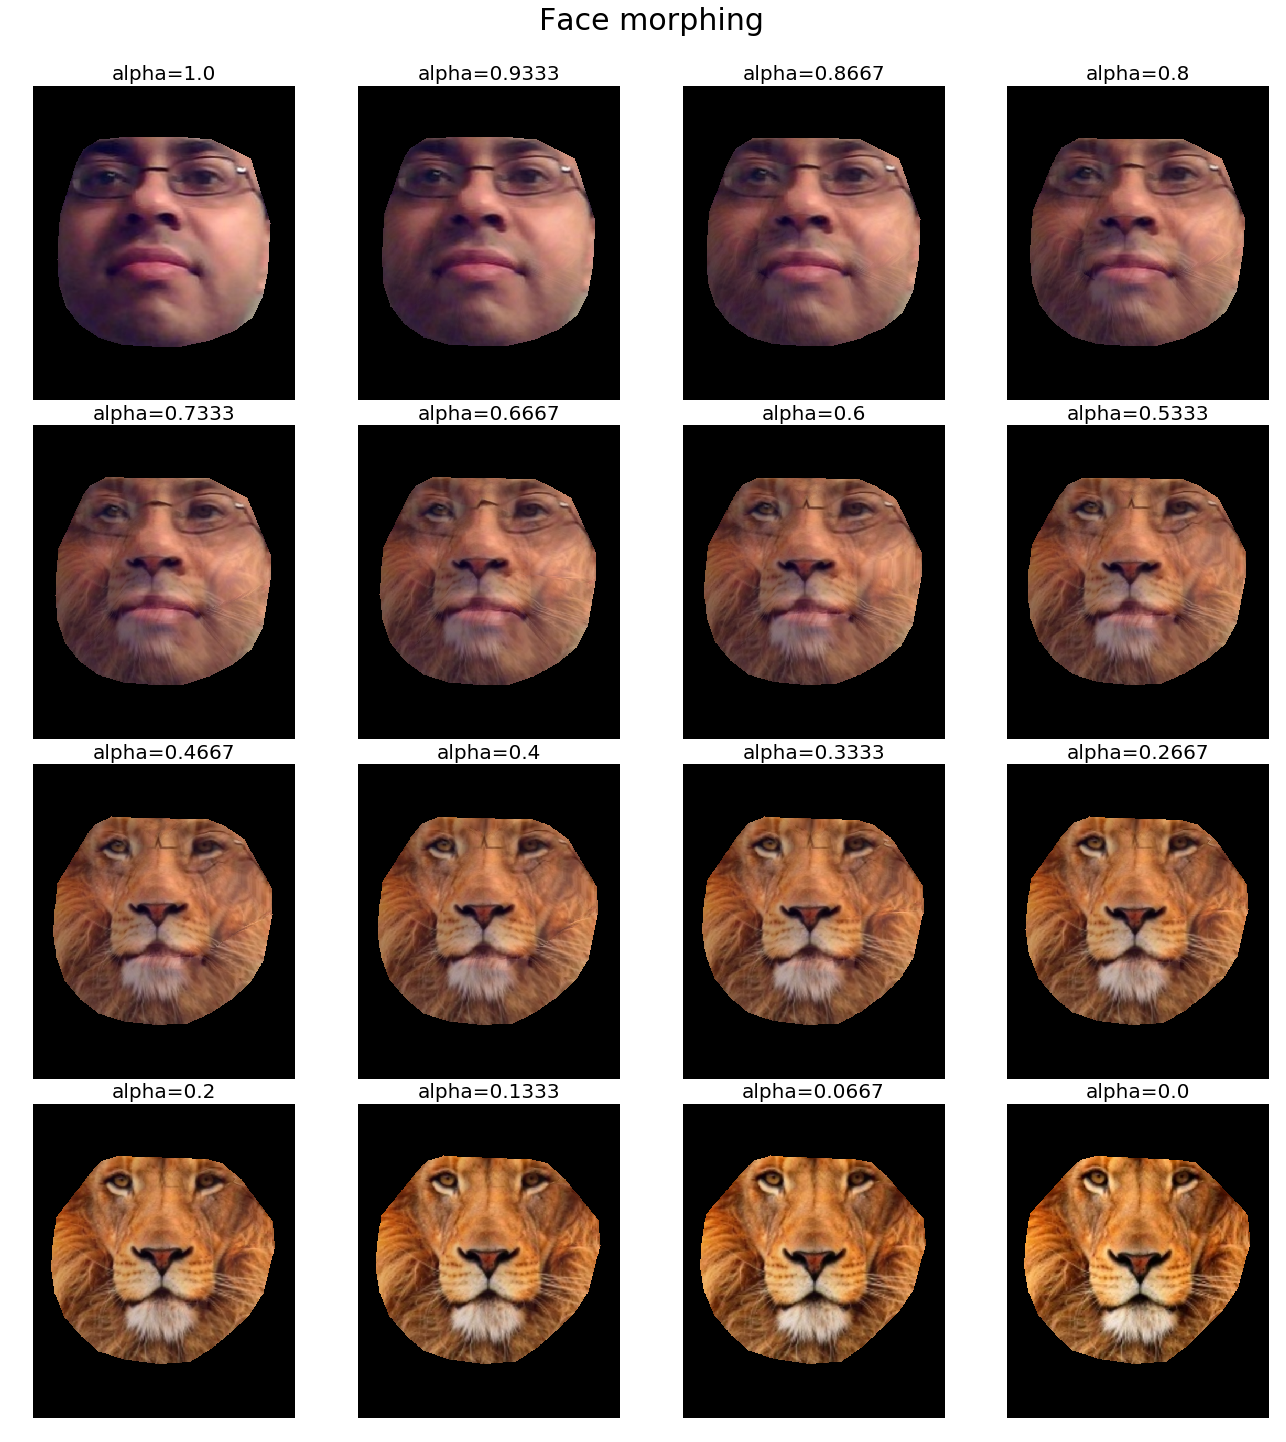

In [49]:
from scipy.spatial import Delaunay
from skimage.io import imread
import scipy.misc
import cv2
import dlib
import numpy as np
from matplotlib import pyplot as plt

def positive_cap(num):
  """ Cap a number to ensure positivity

  :param num: positive or negative number
  :returns: (overflow, capped_number)
  """
  if num < 0:
    return 0, abs(num)
  else:
    return num, 0

def roi_coordinates(rect, size, scale):
  """ Align the rectangle into the center and return the top-left coordinates
  within the new size. If rect is smaller, we add borders.

  :param rect: (x, y, w, h) bounding rectangle of the face
  :param size: (width, height) are the desired dimensions
  :param scale: scaling factor of the rectangle to be resized
  :returns: 4 numbers. Top-left coordinates of the aligned ROI.
    (x, y, border_x, border_y). All values are > 0.
  """
  rectx, recty, rectw, recth = rect
  new_height, new_width = size
  mid_x = int((rectx + rectw/2) * scale)
  mid_y = int((recty + recth/2) * scale)
  roi_x = mid_x - int(new_width/2)
  roi_y = mid_y - int(new_height/2)

  roi_x, border_x = positive_cap(roi_x)
  roi_y, border_y = positive_cap(roi_y)
  return roi_x, roi_y, border_x, border_y

def scaling_factor(rect, size):
  """ Calculate the scaling factor for the current image to be
      resized to the new dimensions

  :param rect: (x, y, w, h) bounding rectangle of the face
  :param size: (width, height) are the desired dimensions
  :returns: floating point scaling factor
  """
  new_height, new_width = size
  rect_h, rect_w = rect[2:]
  height_ratio = rect_h / new_height
  width_ratio = rect_w / new_width
  scale = 1
  if height_ratio > width_ratio:
    new_recth = 0.8 * new_height
    scale = new_recth / rect_h
  else:
    new_rectw = 0.8 * new_width
    scale = new_rectw / rect_w
  return scale

def resize_image(img, scale):
  """ Resize image with the provided scaling factor

  :param img: image to be resized
  :param scale: scaling factor for resizing the image
  """
  cur_height, cur_width = img.shape[:2]
  new_scaled_height = int(scale * cur_height)
  new_scaled_width = int(scale * cur_width)

  return cv2.resize(img, (new_scaled_width, new_scaled_height))

def resize_align(img, points, size):
  """ Resize image and associated points, align face to the center
    and crop to the desired size

  :param img: image to be resized
  :param points: *m* x 2 array of points
  :param size: (height, width) tuple of new desired size
  """
  new_height, new_width = size

  # Resize image based on bounding rectangle
  rect = cv2.boundingRect(np.array([points], np.int32))
  scale = scaling_factor(rect, size)
  img = resize_image(img, scale)

  # Align bounding rect to center
  cur_height, cur_width = img.shape[:2]
  roi_x, roi_y, border_x, border_y = roi_coordinates(rect, size, scale)
  roi_h = np.min([new_height-border_y, cur_height-roi_y])
  roi_w = np.min([new_width-border_x, cur_width-roi_x])

  # Crop to supplied size
  crop = np.zeros((new_height, new_width, 3), img.dtype)
  crop[border_y:border_y+roi_h, border_x:border_x+roi_w] = (
     img[roi_y:roi_y+roi_h, roi_x:roi_x+roi_w])

  # Scale and align face points to the crop
  points[:, 0] = (points[:, 0] * scale) + (border_x - roi_x)
  points[:, 1] = (points[:, 1] * scale) + (border_y - roi_y)

  return (crop, points)

def boundary_points(points):
  """ Produce additional boundary points

  :param points: *m* x 2 np array of x,y points
  :returns: 2 additional points at the top corners
  """
  x, y, w, h = cv2.boundingRect(points)
  buffer_percent = 0.1
  spacerw = int(w * buffer_percent)
  spacerh = int(h * buffer_percent)
  return [[x+spacerw, y+spacerh],
          [x+w-spacerw, y+spacerh]]

def face_points(img, add_boundary_points=True, predictor_path = 'images/shape_predictor_68_face_landmarks.dat'):
  """ Locates 70 face points using dlib

  :param img: an image array
  :param add_boundary_points: bool to add 2 additional points
  :returns: Array of x,y face points. Empty array if no face found
  """
  
  detector = dlib.get_frontal_face_detector()
  predictor = dlib.shape_predictor(predictor_path)
  try:
    #points = stasm.search_single(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))
    dets = detector(img, 1)
    points = np.zeros((68, 2))
    for k, d in enumerate(dets):
        #rint("Detection {}: Left: {} Top: {} Right: {} Bottom: {}".format(
        #   k, d.left(), d.top(), d.right(), d.bottom()))
        # Get the landmarks/parts for the face in box d.
        shape = predictor(img, d)
        for i in range(68):
            points[i, 0] = shape.part(i).x
            points[i, 1] = shape.part(i).y

  except Exception as e:
    print('Failed finding face points: ', e)
    return []

  points = points.astype(np.int32)
  if len(points) == 0:
    return points

  if add_boundary_points:
    return np.vstack([points, boundary_points(points)])

  return points

def weighted_average_points(start_points, end_points, percent=0.5):
  """ Weighted average of two sets of supplied points

  :param start_points: *m* x 2 array of start face points.
  :param end_points: *m* x 2 array of end face points.
  :param percent: [0, 1] percentage weight on start_points
  :returns: *m* x 2 array of weighted average points
  """
  if percent <= 0:
    return end_points
  elif percent >= 1:
    return start_points
  else:
    return np.asarray(start_points*percent + end_points*(1-percent), np.int32)

def weighted_average(img1, img2, percent=0.5):
  if percent <= 0:
    return img2
  elif percent >= 1:
    return img1
  else:
    return cv2.addWeighted(img1, percent, img2, 1-percent, 0)

def mask_from_points(size, points):
  radius = 10  # kernel size
  kernel = np.ones((radius, radius), np.uint8)

  mask = np.zeros(size, np.uint8)
  cv2.fillConvexPoly(mask, cv2.convexHull(points), 255)
  mask = cv2.erode(mask, kernel)

  return mask


def bilinear_interpolate(img, coords):
  """ Interpolates over every image channel
  http://en.wikipedia.org/wiki/Bilinear_interpolation

  :param img: max 3 channel image
  :param coords: 2 x _m_ array. 1st row = xcoords, 2nd row = ycoords
  :returns: array of interpolated pixels with same shape as coords
  """
  int_coords = np.int32(coords)
  x0, y0 = int_coords
  dx, dy = coords - int_coords

  # 4 Neighour pixels
  q11 = img[y0, x0]
  q21 = img[y0, x0+1]
  q12 = img[y0+1, x0]
  q22 = img[y0+1, x0+1]

  btm = q21.T * dx + q11.T * (1 - dx)
  top = q22.T * dx + q12.T * (1 - dx)
  inter_pixel = top * dy + btm * (1 - dy)

  return inter_pixel.T

def grid_coordinates(points):
  """ x,y grid coordinates within the ROI of supplied points

  :param points: points to generate grid coordinates
  :returns: array of (x, y) coordinates
  """
  xmin = np.min(points[:, 0])
  xmax = np.max(points[:, 0]) + 1
  ymin = np.min(points[:, 1])
  ymax = np.max(points[:, 1]) + 1
  return np.asarray([(x, y) for y in range(ymin, ymax)
                     for x in range(xmin, xmax)], np.uint32)

def process_warp(src_img, result_img, tri_affines, dst_points, delaunay):
  """
  Warp each triangle from the src_image only within the
  ROI of the destination image (points in dst_points).
  """
  roi_coords = grid_coordinates(dst_points)
  # indices to vertices. -1 if pixel is not in any triangle
  roi_tri_indices = delaunay.find_simplex(roi_coords)

  for simplex_index in range(len(delaunay.simplices)):
    coords = roi_coords[roi_tri_indices == simplex_index]
    num_coords = len(coords)
    out_coords = np.dot(tri_affines[simplex_index], np.vstack((coords.T, np.ones(num_coords))))
    x, y = coords.T
    result_img[y, x] = bilinear_interpolate(src_img, out_coords)

  return None

def triangular_affine_matrices(vertices, src_points, dest_points):
  """
  Calculate the affine transformation matrix for each
  triangle (x,y) vertex from dest_points to src_points

  :param vertices: array of triplet indices to corners of triangle
  :param src_points: array of [x, y] points to landmarks for source image
  :param dest_points: array of [x, y] points to landmarks for destination image
  :returns: 2 x 3 affine matrix transformation for a triangle
  """
  ones = [1, 1, 1]
  for tri_indices in vertices:
    src_tri = np.vstack((src_points[tri_indices, :].T, ones))
    dst_tri = np.vstack((dest_points[tri_indices, :].T, ones))
    mat = np.dot(src_tri, np.linalg.inv(dst_tri))[:2, :]
    yield mat

def warp_image(src_img, src_points, dest_points, dest_shape, dtype=np.uint8):
  # Resultant image will not have an alpha channel
  num_chans = 3
  src_img = src_img[:, :, :3]

  rows, cols = dest_shape[:2]
  result_img = np.zeros((rows, cols, num_chans), dtype)

  delaunay = Delaunay(dest_points)
  tri_affines = np.asarray(list(triangular_affine_matrices(delaunay.simplices, src_points, dest_points)))

  process_warp(src_img, result_img, tri_affines, dest_points, delaunay)

  return result_img, delaunay

def alpha_image(img, points):
  mask = mask_from_points(img.shape[:2], points)
  return np.dstack((img, mask))

def read_lion_landmark():    
    with open("images/lion_face_landmark.txt") as key_file:
        keypoints = [list(map(int, line.split())) for line in key_file]
        return(keypoints)    

# Load source image
src_path = 'images/me.jpg'
dst_path = 'images/lion.jpg' 

src_img = imread(src_path)
dst_img = imread(dst_path)

# Define control points for warps
src_points = face_points(src_img)
dst_points = face_points(dst_img)

dst_points = np.array(read_lion_landmark())

size = (600, 500)
src_img, src_points = resize_align(src_img, src_points, size)
dst_img, dst_points = resize_align(dst_img, dst_points, size)

fig = plt.figure(figsize=(20,10))
plt.subplot(121)
plt.imshow(src_img)
for i in range(70):
    plt.plot(src_points[i,0], src_points[i,1], 'r.', markersize=20)
plt.title('Source image', size=20)
plt.axis('off')
plt.subplot(122)
plt.imshow(dst_img)
for i in range(70):
    plt.plot(dst_points[i,0], dst_points[i,1], 'g.', markersize=20)
plt.title('Destination image', size=20)
plt.axis('off')
plt.suptitle('Facial Landmarks computed for the images', size=30)
fig.subplots_adjust(wspace=0.01, left=0.1, right=0.9)
plt.show()
fig = plt.figure(figsize=(20,10))
plt.subplot(121)
plt.imshow(src_img)
plt.triplot(src_points[:,0], src_points[:,1], src_d.simplices.copy())
plt.plot(src_points[:,0], src_points[:,1], 'o', color='red')
plt.title('Source image', size=20)
plt.axis('off')
plt.subplot(122)
plt.imshow(dst_img)
plt.triplot(dst_points[:,0], dst_points[:,1], end_d.simplices.copy())
plt.plot(dst_points[:,0], dst_points[:,1], 'o')
plt.title('Destination image', size=20)
plt.axis('off')
plt.suptitle('Delaunay triangulation of the images', size=30)
fig.subplots_adjust(wspace=0.01, left=0.1, right=0.9)
plt.show()

alpha = False
fig = plt.figure(figsize=(18,20))
fig.subplots_adjust(top=0.925, bottom=0, left=0, right=1, wspace=0.01, hspace=0.08)
i = 1
for percent in np.linspace(1, 0, 16):
    points = weighted_average_points(src_points, dst_points, percent)
    src_face, src_d = warp_image(src_img, src_points, points, size)
    end_face, end_d = warp_image(dst_img, dst_points, points, size)
    average_face = weighted_average(src_face, end_face, percent)
    average_face = alpha_image(average_face, points) if alpha else average_face
    plt.subplot(4,4,i)
    plt.imshow(average_face)
    plt.title('alpha=' + str(round(percent,4)), size=20)
    plt.axis('off')
    i += 1
plt.suptitle('Face morphing', size=30)
plt.show()